In [1]:
import pandas as pd
import numpy as np
import intake

In [2]:
cat = intake.open_catalog('../catalogs/catalog.yml')
measures = cat.measures.read().set_index('cdtfa_id')
measures['pct_transit_unspecified'] = abs(measures['total_pct_transit'].fillna(0) -
                                       measures['pct_transit_capital'].fillna(0) -
                                      measures['pct_transit_ops'].fillna(0)).round(0)

In [3]:
measures[measures['county_name'] == 'Santa Clara']

,ballot_designation,county_fips,county_name,county_and_measure,lost_rate,total_pct_transit,pct_transit_ops,pct_transit_capital,pct_local_return,pct_hwy,pct_streets,pct_discretionary,year,amendable,change_feq,two_thirds_req,pct_transit_unspecified
cdtfa_id,,,,,,,,,,,,,,,,,
3,Measure A,6085,Santa Clara,Santa Clara Measure A,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,NaN,NaN,0.0
123,Measure B,6085,Santa Clara,Santa Clara Measure B,0.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
280,Measure B,6085,Santa Clara,Santa Clara Measure B,0.005,0.4784,0.1292,0.3492,0.1905,0.2381,NaN,NaN,2016.0,NaN,NaN,NaN,0.0


In [4]:
def county_lost_narrative(measures_df, county_name):
    measure_info = ''
    county_df = measures_df[measures_df['county_name'] == county_name]
    for _ix, row in county_df.iterrows():
        measure_info += f'* {row.ballot_designation}, enacted {int(row.year)}, {row.lost_rate * 100} percent sales tax\n'
    return measure_info

## Los Angeles County

### LOST Measures
* Prop A (year/rate/etc for each)
* Prop C
* Measure R
* Measure M

In [5]:
print(county_lost_narrative(measures, 'Los Angeles'))

* Proposition A, enacted 1980, 0.5 percent sales tax
* Proposition C, enacted 1990, 0.5 percent sales tax
* Measure R, enacted 2008, 0.5 percent sales tax
* Measure M, enacted 2016, 0.5 percent sales tax



_chart of funding split across all measures_

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ucla')

In [105]:
def county_lost_chart(measures_df, county_name):
    
    plot_columns = ['pct_transit_ops', 'pct_transit_capital', 'pct_transit_unspecified', 'pct_hwy',
               'pct_local_return', 'pct_streets', 'pct_discretionary']
    display_columns = ['Transit Operations', 'Transit Capital', 'Transit Unspecified',
                  'Highway', 'Local Return', 'Streets', 'Discretionary']
    
    county_measures = measures_df[measures_df['county_name'] == county_name]
    
    county_measures = county_measures.rename(columns=dict(zip(plot_columns, display_columns)))
#     display(county_measures)
    to_plot = county_measures[display_columns].multiply(county_measures['lost_rate'], axis='index').sum()
    to_plot = to_plot.rename('total_rate')
    to_plot = pd.DataFrame(to_plot)
    to_plot['Percentage'] = (100 * to_plot['total_rate'] / to_plot['total_rate'].sum()).round(0).astype(int)
    to_plot.index = to_plot.index + ', ' + to_plot['Percentage'].astype(str) + '%'
    to_plot.rename(columns={'Percentage':county_name}, inplace=True) #remove 'Percentage' label from chart
    
    fig, ax = plt.subplots(figsize=(200,200))
    ax = to_plot[county_name].plot.pie(y=0, figsize=(5,5), legend=False)
    plt.savefig(f'../reports/figures/{county_name}_lost.png', bbox_inches = "tight")
    return

In [108]:
def all_county_charts():
    for county_name in measures['county_name'].unique():
        try:
            county_lost_chart(measures, county_name)
        except:
            print(f'Chart failed for {county_name}')
    return

<ipython-input-105-43bfbac5e7a3>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(200,200))


Chart failed for Sonoma/Marin


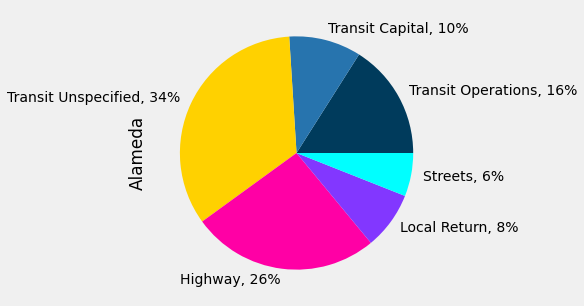

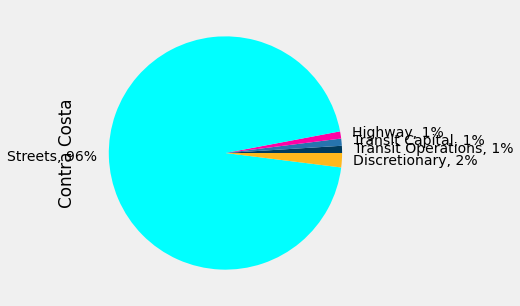

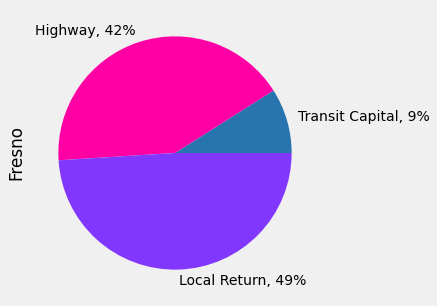

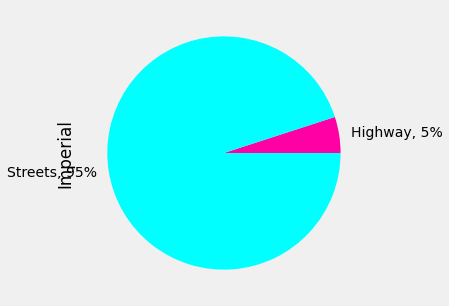

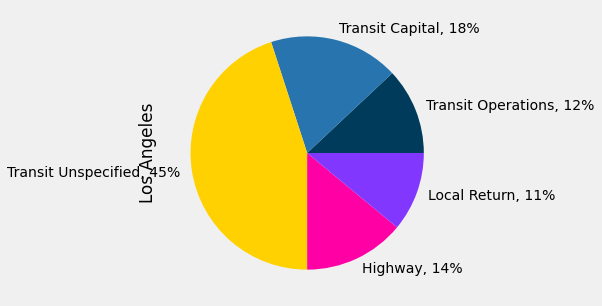

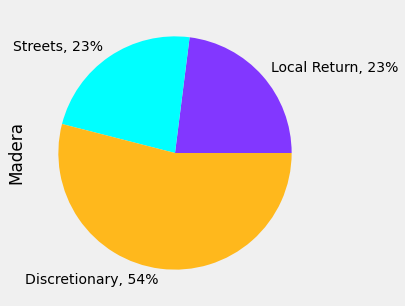

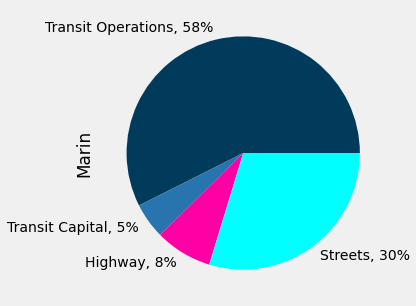

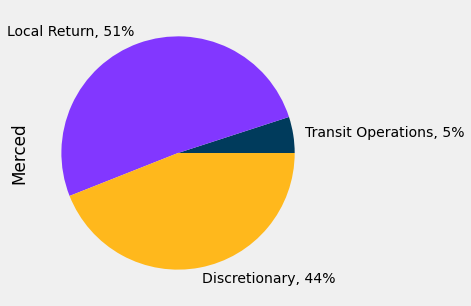

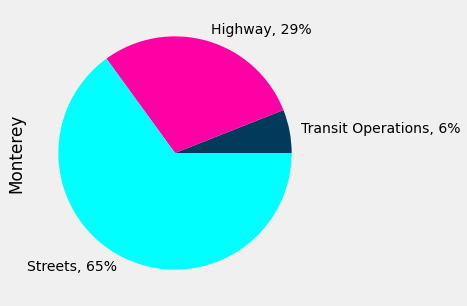

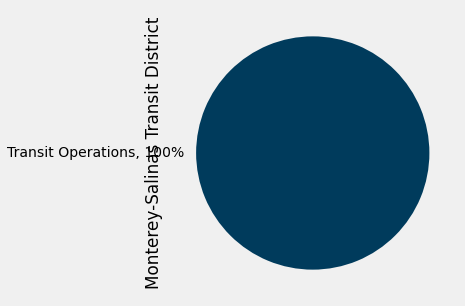

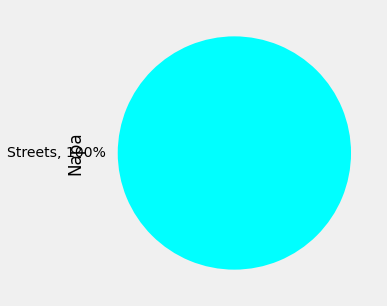

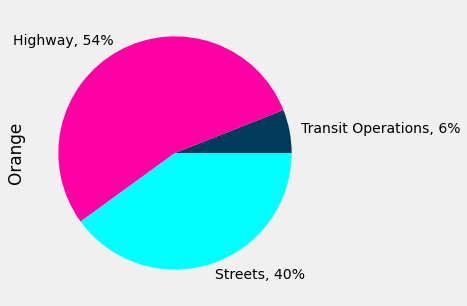

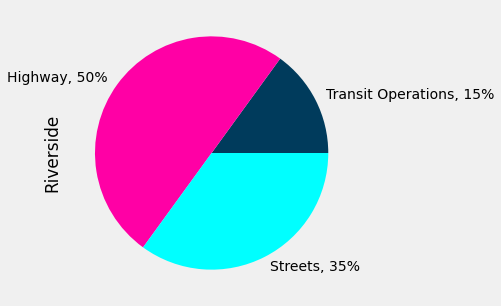

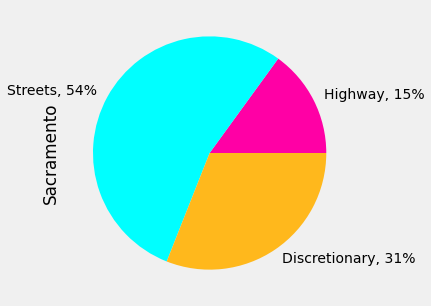

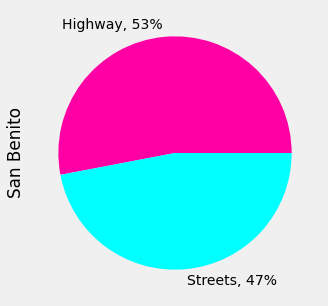

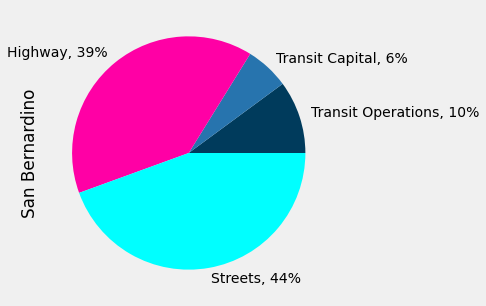

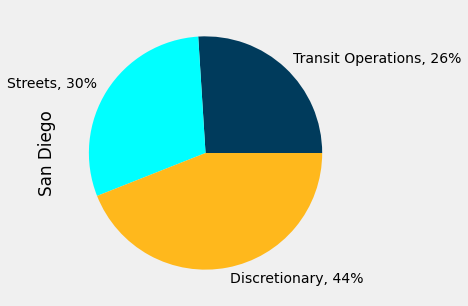

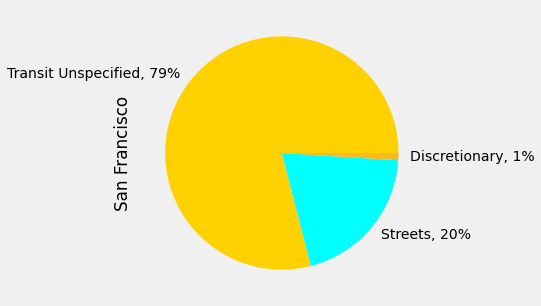

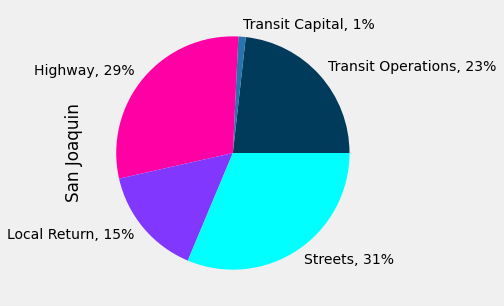

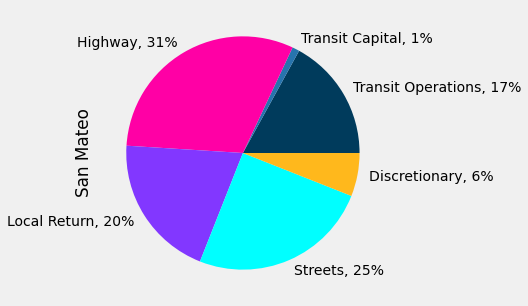

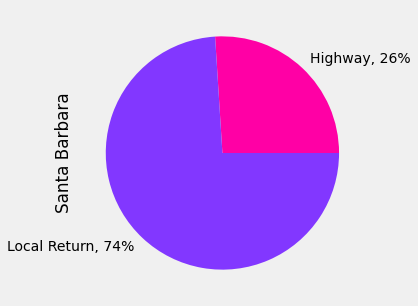

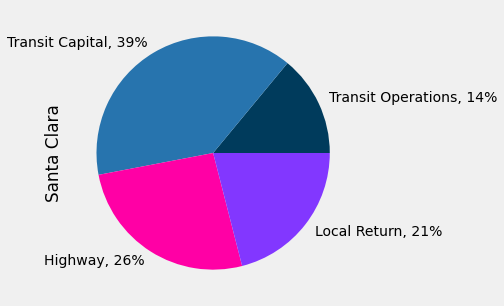

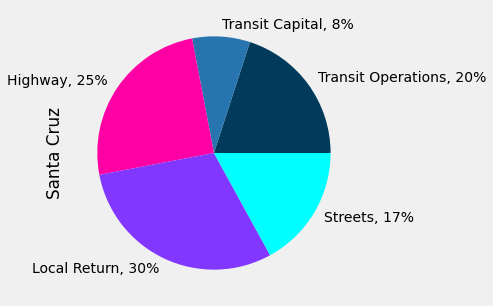

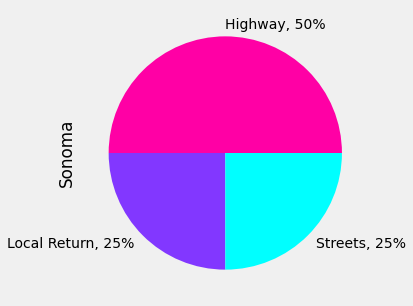

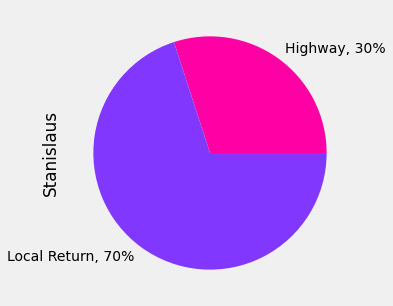

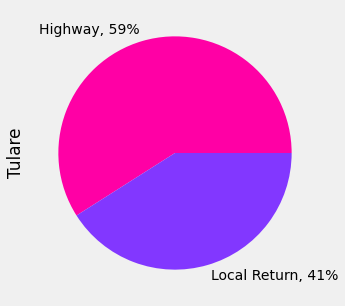

In [109]:
all_county_charts()

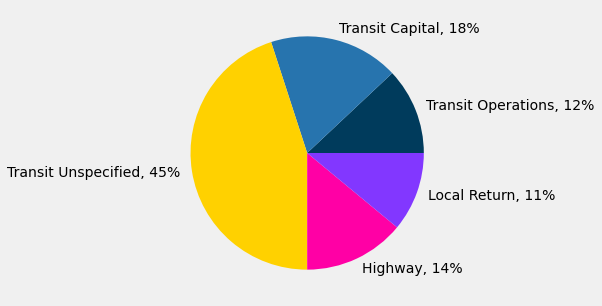

In [101]:
county_lost_chart(measures, 'Los Angeles')

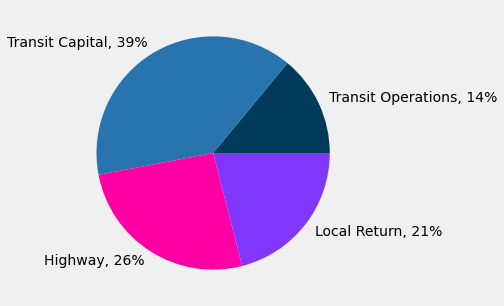

In [81]:
county_lost_chart(measures, 'Santa Clara')

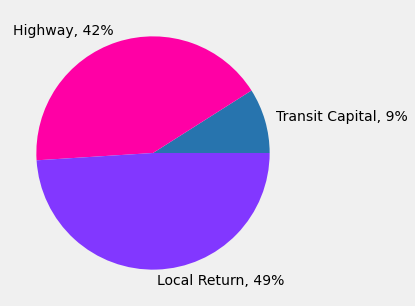

In [82]:
county_lost_chart(measures, 'Fresno')

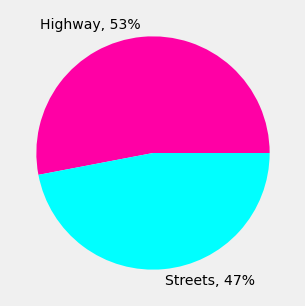

In [83]:
county_lost_chart(measures, 'San Benito')

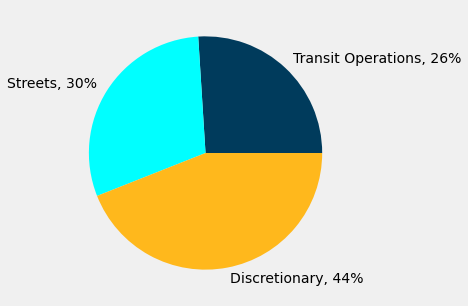

In [85]:
county_lost_chart(measures, 'San Diego')

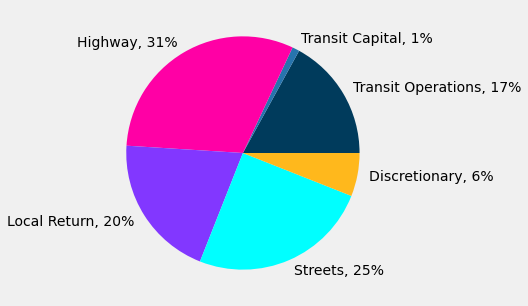

In [86]:
county_lost_chart(measures, 'San Mateo')

In [11]:
sco_url = 'https://bythenumbers.sco.ca.gov/download/6dj3-r4jw/application%2Fvnd.openxmlformats-officedocument.spreadsheetml.sheet'

In [12]:
sco_entities = pd.read_excel(sco_url, sheet_name='ENTITIES')

In [13]:
sco_rev_exp = pd.read_excel(sco_url, sheet_name='TO_REV_EXP')
sco_rev_exp = sco_rev_exp[sco_rev_exp['Fiscal Year'] == 2019]

In [14]:
la_entities = sco_entities[sco_entities['County Name'] == 'Los Angeles'][['Entity ID']]

In [15]:
la_joined = la_entities.set_index('Entity ID').join(sco_rev_exp.set_index('Entity ID'))

In [16]:
la_joined = la_joined[la_joined.columns[la_joined.columns.str.contains('Actual.*Revenues|Entity*')]]

In [17]:
la_joined['Total_Revenues'] = la_joined['Total Operating Revenues_ Actual_Operating Revenues'] + la_joined['Total Nonoperating Revenues_ Actual_Nonoperating Revenues']

In [18]:
la_joined.sort_values('Total_Revenues', ascending=False)

,Entity Name,Passenger Fares_ Actual_Operating Revenues,Park-and-Ride Parking Revenues_ Actual_Operating Revenues,School Bus Service Revenues_Nonpublic Transportation Revenues_ Actual_Operating Revenues,Other Nonpublic Transportation Revenues_Nonpublic Transportation Revenues_ Actual_Operating Revenues,Auxiliary Transportation Funds_ Actual_Operating Revenues,Revenues Accrued through a Purchased Transportation Agreement_ Actual_Operating Revenues,Subsidy from Other Sectors of Operations_ Actual_Operating Revenues,Other Operating Revenues_ Actual_Operating Revenues,Total Operating Revenues_ Actual_Operating Revenues,...,Other Federal Funds_Federal Funds_ Actual_Nonoperating Revenues,Contributed Services_Nonadded Revenues_ Actual_Nonoperating Revenues,Voluntary Nonexchange Transactions_Nonadded Revenues_ Actual_Nonoperating Revenues,Sales and Disposals of Assets_Nonadded Revenues_ Actual_Nonoperating Revenues,Transportation Development Credits_Nonadded Revenues_ Actual_Nonoperating Revenues,Other Nonadded Revenues_Nonadded Revenues_ Actual_Nonoperating Revenues,Total Recoveries_ Actual_Nonoperating Revenues,Other Nonoperating Revenues_ Actual_Nonoperating Revenues,Total Nonoperating Revenues_ Actual_Nonoperating Revenues,Total_Revenues
Entity ID,,,,,,,,,,,,,,,,,,,,,
558,Los Angeles County Metropolitan Transportation...,265289193.0,2763032.0,NaN,NaN,25895391.0,NaN,64223212.0,13546022.0,371716850,...,NaN,NaN,NaN,182882.0,NaN,NaN,NaN,12360239.0,696604477,1068321327
677,Southern California Regional Rail Authority,82157075.0,NaN,NaN,NaN,15184239.0,NaN,NaN,3300718.0,100642032,...,22952196.0,NaN,NaN,55195.0,NaN,NaN,NaN,30489700.0,261094306,361736338
12604,Access Services for Los Angeles County CTSA - ...,10260845.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10260845,...,NaN,NaN,NaN,523715.0,NaN,NaN,NaN,196555.0,167545396,177806241
514,Foothill Transit,16079596.0,NaN,NaN,534612.0,511739.0,129396.0,NaN,66095.0,17321438,...,NaN,NaN,NaN,71329.0,NaN,NaN,NaN,6082076.0,83587120,100908558
555,Long Beach Public Transportation Company,14103478.0,NaN,NaN,292292.0,1093437.0,NaN,NaN,NaN,15489207,...,220287.0,NaN,NaN,NaN,NaN,NaN,146485.0,23437.0,80057370,95546577
9916,Los Angeles,11344509.0,NaN,NaN,NaN,883221.0,NaN,21263527.0,52269211.0,85760468,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,85760468
660,Santa Monica,11413826.0,NaN,NaN,NaN,2046090.0,476219.0,536606.0,2311801.0,16784542,...,NaN,NaN,NaN,59881.0,NaN,NaN,76978.0,1016451.0,59663366,76447908
447,Antelope Valley Transit Authority,4826578.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4826578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,808735.0,38361315,43187893
574,Montebello,9255428.0,NaN,NaN,NaN,62499.0,NaN,NaN,226350.0,9544277,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26191330,35735607


### Transit Operators
* LA Metro
* Foothill Transit
* Santa Monica Big Blue Bus
* Culver City Bus
* Torrance Transit

2019 ridership, modes operated, 

_chart of transit funding sources across all operators_

_statistics about transit ridership, rider demographics..._

### Narrative/Passenger Fares and TDA?
(our estimate of countywide farebox requirement, LOST operations resources?)